## MLC HW 4

### Question 1 (40 points)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County, PA.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

* We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

* Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

* When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

In [1]:
import pandas as pd
import numpy as np
Data1=pd.read_csv("PittsburghTrafficCounts.csv")
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0


In [2]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel
np.random.seed(1)

In [3]:
X = np.array(Data1.iloc[:, 0:2])
y = np.array(np.log(Data1[['AvgDailyTrafficCount']])-np.mean(np.log(Data1[['AvgDailyTrafficCount']])))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

#### 1) The kernel after parameter optimization and fitting to the observed data. (10 pts)

In [4]:
kernel = 1.* RBF(length_scale=1., length_scale_bounds=(1e-3, 1e3)) \
    + WhiteKernel(noise_level=1., noise_level_bounds=(1e-10, 1e10))

gp = GaussianProcessRegressor(kernel=kernel,random_state=1)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X_train, y_train)
y_pred, sigma = gp.predict(X_test, return_std=True)

print (gp.kernel_)

0.652**2 * RBF(length_scale=0.0379) + WhiteKernel(noise_level=0.564)


#### 2) The log marginal likelihood of the training data. (5 pts)

In [5]:
print (gp.log_marginal_likelihood_value_)

-1093.0506624449192


#### 3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

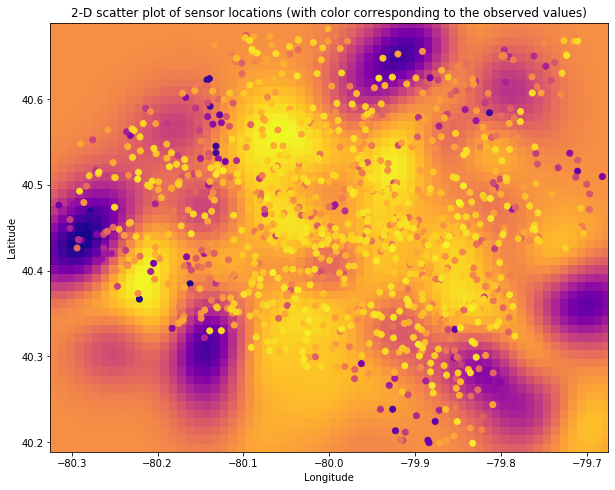

In [6]:
h = 0.01

x_min, x_max = X[:, 0].min() - 0.01, X[:, 0].max() + 0.01
y_min, y_max = X[:, 1].min() - 0.01, X[:, 1].max() + 0.01

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = gp.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(len(np.arange(y_min, y_max, h)),len(np.arange(x_min, x_max, h)))


plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)

#plot the mesh
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), cmap=plt.cm.plasma)

#plot the scatter
plt.scatter(X[:,0], X[:,1], c=np.squeeze(y), cmap=plt.cm.plasma)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("2-D scatter plot of sensor locations (with color corresponding to the observed values)")
plt.show()


#### 4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

In [7]:
pred = gp.predict(X)
std = pred.std()
mean = pred.mean()
anomaly = Data1[abs(y - mean) > 2 * std]
percent = len(anomaly)/len(Data1)*100
print('The percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location is :')
print("{0:.0f}%".format(percent))

The percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location is :
14%


#### 5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)

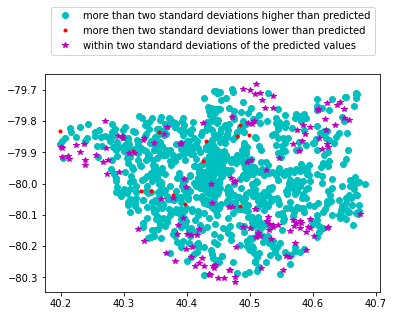

In [8]:
higher = Data1[(y - mean) > 2 * std]
lower = Data1[(y - mean) < -2 * std]
within = Data1[abs(y - mean) < 2 * std]
plt.plot(within['Latitude'],within['Longitude'],'co',label = 'more than two standard deviations higher than predicted')
plt.plot(higher['Latitude'],higher['Longitude'],'r.', label = 'more then two standard deviations lower than predicted')
plt.plot(lower['Latitude'],lower['Longitude'],'m*', label = 'within two standard deviations of the predicted values')
plt.legend(bbox_to_anchor=(1, 1.2), loc='center right', ncol=1)

### Question 2: Cluster-based anomaly detection (10 points)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 100 points, center (0, 0), standard deviation 0.1

B: 150 points, center (35, 5), standard deviation 5

C: 2 points, center (15, 20), standard deviation 1

D: 200 points, center (10, 10), standard deviation 1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(1, 0)		Anomaly / Not Anomaly


(35, 2)		Anomaly / Not Anomaly


(15, 19)	Anomaly / Not Anomaly


(10, 11)	Anomaly / Not Anomaly


#### Your solution here

(1, 0) Anomaly, the position of this point is far away from the center of any of the above clusters given the standard diviation.

(35, 2) Not Anomaly, this point can be one of the points in cluster B.

(15, 19) Anomaly, since the C cluster is tiny cluster. If we report tiny cluster when the number of records <= k, k<=3, then C is a tiny cluster which means the records in this cluster are anomalies.

(10, 11)  Not Anomaly, this point can be one of the points in cluster D.

### Question 3: Anomaly detection (50 points)

For this question, use the "County Health Indicators" dataset provided to identify the most anomalous counties. Please list the top 5 most anomalous counties computed using each of the following models.  (We recommend that, as a pre-processing step, you drop na values, and make sure all numeric values are treated as floats not strings.)

In [9]:
Data2=pd.read_csv("2016CountyHealthIndicators.csv")
Data2.head()

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",19,4.4,4.3,9,19,31,7.1,29,71,...,18,4.3,27,13.8,254,76,12.9,14,89,42
1,"Baldwin, Alabama",16,4.1,4.2,9,19,27,7.6,25,72,...,20,4.5,28,12.0,221,70,13.1,15,84,37
2,"Barbour, Alabama",26,4.9,4.7,12,21,41,5.1,33,45,...,38,5.3,54,8.1,147,64,12.6,18,84,35
3,"Bibb, Alabama",22,4.8,4.6,12,21,40,7.4,33,33,...,27,4.3,32,9.8,236,75,12.9,13,84,46
4,"Blount, Alabama",21,4.6,4.5,7,19,32,8.3,29,26,...,24,4.1,28,8.5,219,89,12.7,12,85,59


In [10]:
Data2[Data2.columns[1:]] = Data2[Data2.columns[1:]].apply(pd.to_numeric, errors='coerce', downcast='float')
Data2.dropna(inplace=True)
Data2.head()

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",19.0,4.4,4.3,9.0,19.0,31.0,7.1,29.0,71.0,...,18.0,4.3,27.0,13.8,254.0,76.0,12.9,14.0,89.0,42.0
1,"Baldwin, Alabama",16.0,4.1,4.2,9.0,19.0,27.0,7.6,25.0,72.0,...,20.0,4.5,28.0,12.0,221.0,70.0,13.1,15.0,84.0,37.0
2,"Barbour, Alabama",26.0,4.9,4.7,12.0,21.0,41.0,5.1,33.0,45.0,...,38.0,5.3,54.0,8.1,147.0,64.0,12.6,18.0,84.0,35.0
3,"Bibb, Alabama",22.0,4.8,4.6,12.0,21.0,40.0,7.4,33.0,33.0,...,27.0,4.3,32.0,9.8,236.0,75.0,12.9,13.0,84.0,46.0
4,"Blount, Alabama",21.0,4.6,4.5,7.0,19.0,32.0,8.3,29.0,26.0,...,24.0,4.1,28.0,8.5,219.0,89.0,12.7,12.0,85.0,59.0


#### Part 1: Learn a Bayesian network structure using only the six features ["'% Smokers'","'% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'% Children in Poverty'","'Average Daily PM2.5'"]. Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4.

(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts)

(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

In [11]:
Data2.set_index('County', inplace=True)
data3 = Data2[["'\% Smokers'","'\% Obese'","'Violent Crime Rate'",
               "'80/20 Income Ratio'","'\% Children in Poverty'",
               "'Average Daily PM2.5'"]]
data3.columns = ['smokers','obese','violent_crime_rate','80/20_income_ratio',
                 'children in poverty','average_daily_pm2.5']
data3.head()

,smokers,obese,violent_crime_rate,80/20_income_ratio,children in poverty,average_daily_pm2.5
County,,,,,,
"Autauga, Alabama",19.0,31.0,254.0,4.3,18.0,12.9
"Baldwin, Alabama",19.0,27.0,221.0,4.5,20.0,13.1
"Barbour, Alabama",21.0,41.0,147.0,5.3,38.0,12.6
"Bibb, Alabama",21.0,40.0,236.0,4.3,27.0,12.9
"Blount, Alabama",19.0,32.0,219.0,4.1,24.0,12.7


In [12]:
data3.iloc[:,0:] = data3.iloc[:,0:].apply(pd.cut, bins=5, labels=False)
data3.head()

/Users/chenjiesu/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/chenjiesu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,smokers,obese,violent_crime_rate,80/20_income_ratio,children in poverty,average_daily_pm2.5
County,,,,,,
"Autauga, Alabama",1,2,0,1,1,3
"Baldwin, Alabama",1,2,0,1,1,3
"Barbour, Alabama",2,4,0,2,3,3
"Bibb, Alabama",2,4,0,1,2,3
"Blount, Alabama",1,2,0,1,2,3


In [13]:
# (a) Use HillClimbSearch and BicScore to learn the Bayesian network structure 
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore
hc = HillClimbSearch(data3, scoring_method=BicScore(data3))
best_model = hc.estimate()
print(best_model.edges())

[('smokers', 'obese'), ('smokers', 'average_daily_pm2.5'), ('80/20_income_ratio', 'children in poverty'), ('children in poverty', 'smokers'), ('children in poverty', 'violent_crime_rate')]


In [14]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator

model = BayesianModel(best_model.edges())
model.fit(data3, estimator=MaximumLikelihoodEstimator)
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of 80/20_income_ratio:
+-----------------------+------------+
| 80/20_income_ratio(0) | 0.131134   |
+-----------------------+------------+
| 80/20_income_ratio(1) | 0.704344   |
+-----------------------+------------+
| 80/20_income_ratio(2) | 0.140386   |
+-----------------------+------------+
| 80/20_income_ratio(3) | 0.0213194  |
+-----------------------+------------+
| 80/20_income_ratio(4) | 0.00281577 |
+-----------------------+------------+
CPD of average_daily_pm2.5:
+------------------------+----------------------+----------------------+----------------------+------------+------------+
| smokers                | smokers(0)           | smokers(1)           | smokers(2)           | smokers(3) | smokers(4) |
+------------------------+----------------------+----------------------+----------------------+------------+------------+
| average_daily_pm2.5(0) | 0.2076923076923077   | 0.053204353083434096 | 0.008888888888888889 | 0.0        | 0.0        |
+------------------------+--

In [15]:
# (b) Which 5 counties have the lowest (most negative) log-likelihood values? 
# Please show a ranked list of the top counties' names and log-likelihood values.

# Log-likelihood of data record x given model
def LL(x,model,verbose=False):
    loglike = 0
    for cpd in model.get_cpds():
        temp_cpd = cpd.copy()
        thevariable = temp_cpd.variable
        theparents = model.predecessors(thevariable)
        for parent in theparents:
            temp_cpd.reduce([(parent, x[parent])])
        theprob = temp_cpd.get_values()[x[thevariable],0]
        if verbose:
            print (thevariable,theparents,theprob)
        loglike += np.log(theprob)
    return loglike

# compute anomalousness of each of the data records
exmp=data3.iloc[:,:].apply(lambda x: LL(x,model),axis=1)
# 5 most anomalous data records
print (exmp.sort_values().head())

County
New York, New York                           -16.608495
San Francisco, California                    -14.827149
Roulette, North Dakota                       -14.686742
Suffolk, Massachusetts                       -14.457849
District of Columbia, District of Columbia   -13.671439
dtype: float64


#### Part 2: Cluster based anomaly detection.  Use all numeric features for this part, and do not discretize. 

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

In [16]:
# a) Clustering with k-means. Please use k=3 clusters. 
# Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances.
from sklearn.cluster import KMeans
KM=KMeans(n_clusters=3,random_state=999)
scor=KM.fit_predict(Data2)

# distance to each cluster center
km=pd.DataFrame(KM.transform(Data2))
km.index = Data2.index
km.head()

,0,1,2
County,,,
"Autauga, Alabama",215.616180,101.858559,554.608765
"Baldwin, Alabama",108.459702,186.169556,655.931458
"Barbour, Alabama",410.502594,282.491516,530.643005
"Bibb, Alabama",168.289185,141.329285,602.378052
"Blount, Alabama",105.181175,314.775635,777.334167


In [17]:
# add cluster and distance information for each data record
km.columns=list(range(3))
km["score"] = km.min(axis=1)
km['cluster'] = km.idxmin(axis=1)
# find data records farthest from cluster centers
km.sort_values(by= ["score"], ascending=False).head()

,0,1,2,score,cluster
County,,,,,
"Shannon, South Dakota",2443.708252,2251.523926,1970.019043,1970.019043,2
"St. Louis City, Missouri",2036.276978,1759.353760,1332.736572,1332.736572,2
"Crittenden, Arkansas",1917.861206,1639.172607,1208.901489,1208.901489,2
"Petersburg City, Virginia",1644.914551,1394.891113,1017.910950,1017.910950,2
"Baltimore City, Maryland",1652.073730,1366.871826,918.375183,918.375183,2


In [18]:
# (b) Cluster with Gaussian Mixture. 
#Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness.
from sklearn.mixture import GaussianMixture
GM=GaussianMixture(n_components=3,random_state=999)
GM.fit(Data2)
gm=pd.DataFrame()
gm["loglikelihood"] = GM.score_samples(Data2)
gm.index = Data2.index
gm.sort_values(by= ["loglikelihood"]).head(5)

,loglikelihood
County,
"Shannon, South Dakota",-197.640278
"Apache, Arizona",-133.169602
"New York, New York",-131.535888
"Willacy, Texas",-129.175633
"Roulette, North Dakota",-126.773260


#### Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose. (10 pts)

In [19]:
from sklearn.neighbors import LocalOutlierFactor
# fit the model
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(Data2)

res = pd.DataFrame()
res["clf_score"] = clf._decision_function(Data2)
res.index = Data2.index
res.sort_values(by="clf_score").head()

,clf_score
County,
"Shannon, South Dakota",-3.047643
"St. Louis City, Missouri",-1.019539
"Crittenden, Arkansas",-0.728699
"Nicholas, West Virginia",-0.645999
"Petersburg City, Virginia",-0.555315


#### Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous. (5 pts)

In [20]:
from functools import reduce

In [21]:
bn_county = pd.DataFrame(exmp.sort_values().head().index)
bn_county['bn'] = 1
km_county = pd.DataFrame(km.sort_values(by= ["score"], ascending=False).head().index)
km_county['km'] = 1
gm_county = pd.DataFrame(gm.sort_values(by= ["loglikelihood"]).head().index)
gm_county['gm'] = 1
lof_county = pd.DataFrame(res.sort_values(by= ["clf_score"]).head().index)
lof_county['lof'] = 1
data_frames = [bn_county, km_county, gm_county, lof_county]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['County'],
                                            how='outer'), data_frames)
df_merged.set_index(["County"], inplace=True)
df_merged['sum'] = df_merged.apply(lambda x: x.sum(),axis=1)
df_merged

,bn,km,gm,lof,sum
County,,,,,
"New York, New York",1.0,NaN,1.0,NaN,2.0
"San Francisco, California",1.0,NaN,NaN,NaN,1.0
"Roulette, North Dakota",1.0,NaN,1.0,NaN,2.0
"Suffolk, Massachusetts",1.0,NaN,NaN,NaN,1.0
"District of Columbia, District of Columbia",1.0,NaN,NaN,NaN,1.0
"Shannon, South Dakota",NaN,1.0,1.0,1.0,3.0
"St. Louis City, Missouri",NaN,1.0,NaN,1.0,2.0
"Crittenden, Arkansas",NaN,1.0,NaN,1.0,2.0
"Petersburg City, Virginia",NaN,1.0,NaN,1.0,2.0


Shannon in South Dakota, which is detected to be anomalous in three different models, is the most abnormal city.
And other big cities like New York and St.louis are detected as anomalies twice.
Maybe we need more or better models to detect anormalies.